Any learning algorithm will always have strengths and weaknesses: a single model is unlikely to fit every possible scenario. Ensembles combine multiple models to achieve higher generalization performance than any of the constituent models is capable of. How do we assemble the weak learners? We can use some sequential heuristics. For instance, given the current collection of models, we can add one more based on where that particular model performs well. Alternatively, we can look at all the correlations of the predictions between all models, and optimize for the most uncorrelated predictors. Since this latter is a global approach, it naturally maps to a quantum computer.

# Ensemble methods

Ensembles yield better results when there is considerable diversity among the base classifiers. If diversity is sufficient, base classifiers make different errors, and a strategic combination may reduce the total error, ideally improving generalization performance. A constituent model in an ensemble is also called a base classifier or weak learner, and the composite model a strong learner.

The generic procedure of ensemble methods has two steps. First, develop a set of base classifiers from the training data. Second, combine them to form the ensemble. In the simplest combination, the base learners vote, and the label prediction is based on majority. More involved methods weigh the votes of the base learners. 

Let us import some packages and define our figure of merit as accuracy in a balanced dataset.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.metrics
%matplotlib inline

metric = sklearn.metrics.accuracy_score

We generate a random dataset of two classes that form concentric circles:

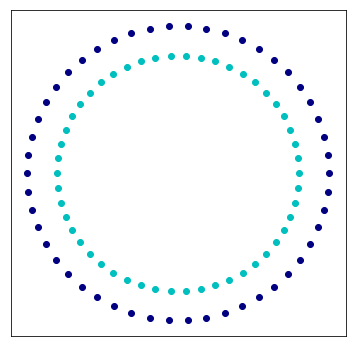

In [2]:
np.random.seed(0)
data, labels = sklearn.datasets.make_circles()
idx = np.arange(len(labels))
np.random.shuffle(idx)
# train on a random 2/3 and test on the remaining 1/3
idx_train = idx[:2*len(idx)//3]
idx_test = idx[2*len(idx)//3:]
X_train = data[idx_train]
X_test = data[idx_test]

y_train = 2 * labels[idx_train] - 1  # binary -> spin
y_test = 2 * labels[idx_test] - 1

scaler = sklearn.preprocessing.StandardScaler()
normalizer = sklearn.preprocessing.Normalizer()

X_train = scaler.fit_transform(X_train)
X_train = normalizer.fit_transform(X_train)

X_test = scaler.fit_transform(X_test)
X_test = normalizer.fit_transform(X_test)
plt.figure(figsize=(6, 6))
plt.subplot(111, xticks=[], yticks=[])
plt.scatter(data[labels == 0, 0], data[labels == 0, 1], color='navy')
plt.scatter(data[labels == 1, 0], data[labels == 1, 1], color='c');

Let's train a perceptron:

In [3]:
from sklearn.linear_model import Perceptron
model_1 = Perceptron()
model_1.fit(X_train, y_train)
print('accuracy (train): %5.2f'%(metric(y_train, model_1.predict(X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, model_1.predict(X_test))))

accuracy (train):  0.55
accuracy (test):  0.41


/Users/manoel/anaconda3/envs/QISKitenv/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Since its decision surface is linear, we get a poor accuracy. Would a support vector machine with a nonlinear kernel fare better?

In [4]:
from sklearn.svm import SVC
model_2 = SVC(kernel='rbf')
model_2.fit(X_train, y_train)
print('accuracy (train): %5.2f'%(metric(y_train, model_2.predict(X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, model_2.predict(X_test))))

accuracy (train):  0.64
accuracy (test):  0.24


/Users/manoel/anaconda3/envs/QISKitenv/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


It performs better on the training set, but at the cost of extremely poor generalization. 

Boosting is an ensemble method that explicitly seeks models that complement one another. The variation between boosting algorithms is how they combine weak learners. Adaptive boosting (AdaBoost) is a popular method that combines the weak learners in a sequential manner based on their individual accuracies. It has a convex objective function that does not penalize for complexity: it is likely to include all available weak learners in the final ensemble. Let's train AdaBoost with a few weak learners:

In [5]:
from sklearn.ensemble import AdaBoostClassifier
model_3 = AdaBoostClassifier(n_estimators=3)
model_3.fit(X_train, y_train)
print('accuracy (train): %5.2f'%(metric(y_train, model_3.predict(X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, model_3.predict(X_test))))

accuracy (train):  0.65
accuracy (test):  0.29


Its performance is marginally better than that of the SVM.

# QBoost

The idea of Qboost is that optimization on a quantum computer is not constrained to convex objective functions, therefore we can add arbitrary penalty terms and rephrase our objective [[1](#1)]. Qboost solves the following problem:

$$
\mathrm{argmin}_{w} \left(\frac{1}{N}\sum_{i=1}^{N}\left(\sum_{k=1}^{K}w_kh_k(x_i)-
y_i\right)^2+\lambda\|w\|_0\right),
$$

where $h_k(x_i)$ is the prediction of the weak learner $k$ for a training instance $k$. The weights in this formulation are binary, so this objective function is already maps to an Ising model. The regularization in the $l_0$ norm ensures sparsity, and it is not the kind of regularization we would consider classically: it is hard to optimize with this term on a digital computer.

Let us expand the quadratic part of the objective:

$$
\mathrm{argmin}_{w} \left(\frac{1}{N}\sum_{i=1}^{N}
\left( \left(\sum_{k=1}^{K} w_k h_k(x_i)\right)^{2} -
2\sum_{k=1}^{K} w_k h_k(\mathbf{x}_i)y_i + y_i^{2}\right) + \lambda \|w\|_{0}
\right).
$$

Since $y_i^{2}$ is just a constant offset, the optimization reduces to

$$
\mathrm{argmin}_{w} \left(
\frac{1}{N}\sum_{k=1}^{K}\sum_{l=1}^{K} w_k w_l
\left(\sum_{i=1}^{N}h_k(x_i)h_l(x_i)\right) - 
\frac{2}{N}\sum_{k=1}^{K}w_k\sum_{i=1}^{N} h_k(x_i)y_i +
\lambda \|w\|_{0} \right).
$$

This form shows that we consider all correlations between the predictions of the weak learners: there is a summation of $h_k(x_i)h_l(x_i)$. Since this term has a positive sign, we penalize for correlations. On the other hand, the correlation with the true label, $h_k(x_i)y_i$, has a negative sign. The regularization term remains unchanged.

Let us consider all three models from the previous section as weak learners.

In [6]:
models = [model_1, model_2, model_3]

We calculate their predictions and set $\lambda$ to 1. The predictions are scaled to reflecting the averaging in the objective.

In [7]:
n_models = len(models)

predictions = np.array([h.predict(X_train) for h in models], dtype=np.float64)
# scale hij to [-1/N, 1/N]
predictions *= 1/n_models

λ = 1

We create the quadratic binary optimization of the objective function as we expanded above:

In [8]:
w = np.dot(predictions, predictions.T)
wii = len(X_train) / (n_models ** 2) + λ - 2 * np.dot(predictions, y_train)
w[np.diag_indices_from(w)] = wii
W = {}
for i in range(n_models):
    for j in range(i, n_models):
        W[(i, j)] = w[i, j]

We solve the quadratic binary optimization with simulated annealing and read out the optimal weights:

In [9]:
import dimod
sampler = dimod.SimulatedAnnealingSampler()
response = sampler.sample_qubo(W, num_reads=10)
weights = list(response.first.sample.values())

We define a prediction function to help with measuring accuracy:

In [10]:
def predict(models, weights, X):

    n_data = len(X)
    T = 0
    y = np.zeros(n_data)
    for i, h in enumerate(models):
        y0 = weights[i] * h.predict(X)  # prediction of weak classifier
        y += y0
        T += np.sum(y0)

    y = np.sign(y - T / (n_data*len(models)))

    return y

In [11]:
print('accuracy (train): %5.2f'%(metric(y_train, predict(models, weights, X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, predict(models, weights, X_test))))

accuracy (train):  0.65
accuracy (test):  0.29


The accuracy co-incides with our strongest weak learner's, the AdaBoost model. Looking at the optimal weights, this is apparent:

In [12]:
weights

[0, 0, 1]

Only AdaBoost made it to the final ensemble. The first two models perform poorly and their predictions are correlated. Yet, if you remove regularization by setting $\lambda=0$ above, the second model also enters the ensemble, decreasing overall performance. This shows that the regularization is in fact important.

# Solving by QAOA

Since eventually our problem is just an Ising model, we can also solve it on a gate-model quantum computer by QAOA. Let us explicitly map the binary optimization to the Ising model:

In [13]:
h, J, offset = dimod.qubo_to_ising(W)

We have to translate the Ising couplings to be suitable for solving by the QAOA routine:

In [14]:
from qiskit.quantum_info import Pauli
from qiskit.aqua import Operator

num_nodes = w.shape[0]
pauli_list = []
for i in range(num_nodes):
    wp = np.zeros(num_nodes)
    vp = np.zeros(num_nodes)
    vp[i] = 1
    pauli_list.append([h[i], Pauli(vp, wp)])
    for j in range(i+1, num_nodes):
        if w[i, j] != 0:
            wp = np.zeros(num_nodes)
            vp = np.zeros(num_nodes)
            vp[i] = 1
            vp[j] = 1
            pauli_list.append([J[i, j], Pauli(vp, wp)])
ising_model = Operator(paulis=pauli_list)

Next we run the optimization:

In [15]:
from qiskit.aqua import QuantumInstance
from qiskit import Aer
from qiskit.aqua.algorithms import QAOA
from qiskit.aqua.components.optimizers import COBYLA
p = 1
optimizer = COBYLA()
qaoa = QAOA(ising_model, optimizer, p, operator_mode='matrix')
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, shots=100)
result = qaoa.run(quantum_instance)

Finally, we extract the most likely solution:

In [16]:
k = np.argmax(result['eigvecs'][0])
weights = np.zeros(num_nodes)
for i in range(num_nodes):
    weights[i] = k % 2
    k >>= 1

Let's see the weights found by QAOA:

In [17]:
weights

array([0., 1., 1.])

And the final accuracy:

In [18]:
print('accuracy (train): %5.2f'%(metric(y_train, predict(models, weights, X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, predict(models, weights, X_test))))

accuracy (train):  0.64
accuracy (test):  0.29


# References

[1] Neven, H., Denchev, V.S., Rose, G., Macready, W.G. (2008). [Training a binary classifier with the quantum adiabatic algorithm](https://arxiv.org/abs/0811.0416). *arXiv:0811.0416*.  <a id='1'></a>